In [24]:
from model import MLPClassifier
from dataloader import get_dataloader
import numpy as np
from utils import simple_accuracy
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import matthews_corrcoef
from data import dataset
import itertools
from tqdm.notebook import tqdm
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
import pandas as pd

In [15]:
# !pip install xgboost
# !pip install seaborn
!pip install imblearn

  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/a3/9e/fbe60a768502af54563dcb59ca7856f5a8833b3ad5ada658922e1ab09b7f/imbalanced_learn-0.11.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 8.7 MB/s eta 0:00:00


In [25]:
DATA_PATH = dataset
LABEL_COLUMN = 'GDvsTI'
EPOCHS = 100
N_BOOTSTRAPS = 100
# features = ['eGFR_CKDEPI2021', 'age', "SeqId_10011_65", "SeqId_10024_44", "SeqId_10040_63", "SeqId_10042_8"]
param_grid = {
    'lr': [1e-2, 1e-3, 1e-4],
    'batch_size': [8, 16, 32],
    'hidden_dims': [(32,), (64, 32), (128, 64, 32)]
}

In [26]:
# Hyperparameter grid
param_grid = {
    'lr': [1e-2, 1e-3, 1e-4],
    'batch_size': [8, 16, 32],
    # Add other hyperparameters here...
}

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the data
df = pd.read_csv(dataset)

# Convert 'Male' to 0 and 'Female' to 1 in the 'sex' column
df['sex'] = df['sex'].map({'Male': 0, 'Female': 1})

# Separate features and labels
X = df.drop(columns=['GDvsTI'])

# Mean imputation for numerical columns
for col in X.columns:
    if X[col].dtype == 'float64' or X[col].dtype == 'int64':
        X[col].fillna(X[col].mean(), inplace=True)
    else:
        X[col].fillna(X[col].mode()[0], inplace=True)

y = df['GDvsTI'].map({1: 1, 2: 0})  # Convert 2 to 0

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA
# Here, I'm keeping 95% of the variance. You can adjust this number or set n_components to a fixed number.
# pca = PCA(n_components=0.95)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# Print the number of components retained after PCA
# print(f"Number of PCA components: {pca.n_components_}")


In [29]:
# X_train
print(y_train_df.isnull().sum())


0


In [30]:
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score

def compute_metrics(y_true, y_pred, y_prob):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)  # Sensitivity
    specificity = tn / (tn + fp)
    f1 = 2 * (precision * recall) / (precision + recall)
    mcc = matthews_corrcoef(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    
    return accuracy, precision, recall, specificity, f1, mcc, roc_auc, pr_auc

In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

classifiers = [
    (MLPClassifier(), {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
    }),
    (RandomForestClassifier(), {
        'n_estimators': [10, 50, 100, 200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [4, 5, 6, 7, 8],
        'criterion': ['gini', 'entropy']
    }),
    (XGBClassifier(), {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.3, 0.5, 0.9]
    }),
    (LinearDiscriminantAnalysis(), {
        'solver': ['svd', 'lsqr', 'eigen']
    }),
    (LogisticRegression(), {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l1', 'l2'],
        'max_iter': [100, 500, 1000]
    }),
    (SVC(probability=True), {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']
})

]

In [10]:


# Define classifiers and their hyperparameter grids


best_models = []
for clf, params in tqdm(classifiers, desc="Grid Searching", unit="model"):
    grid_search = GridSearchCV(clf, params, cv=5)
    grid_search.fit(X_train, y_train)
    best_models.append((clf.__class__.__name__, grid_search.best_estimator_, grid_search.best_score_))
    
    # Predict on the test set and print confusion matrix
    y_pred = grid_search.best_estimator_.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title(f'Confusion Matrix for {clf.__class__.__name__}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

# Sort models based on score
best_models = sorted(best_models, key=lambda x: x[2], reverse=True)

# Print the best model
print(f"Best Model: {best_models[0][0]} with score {best_models[0][2]}")






Grid Searching:   0%|          | 0/6 [00:00<?, ?model/s]

/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning

In [44]:
# 25 min to run

from imblearn.over_sampling import SMOTE
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import numpy as np

def bootstrap_evaluation(model, X_train, y_train, X_test, y_test, n_iter=100):
    metrics_list = []
    confusion_matrices = []

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    for i in tqdm(range(n_iter), desc="Bootstrap Iterations"):
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)
        
        # Check if the model has the predict_proba method
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        else:
            y_prob = y_pred  # Use predicted labels as probabilities for models without predict_proba
        
        metrics_list.append(compute_metrics(y_test, y_pred, y_prob))
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(cm)

    metrics_df = pd.DataFrame(metrics_list, columns=['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1', 'MCC', 'ROC_AUC', 'PR_AUC'])
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()
    avg_cm = np.mean(confusion_matrices, axis=0)
    
    return mean_metrics, std_metrics, avg_cm



In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming metrics_df is your DataFrame containing the metrics for each model

# Reshape the data to long format
long_format = pd.melt(metrics_df, id_vars=['Model'], value_vars=['ROC_AUC', 'PR_AUC'])

# Plot AUC of ROC
plt.figure(figsize=(12, 6))
sns.boxenplot(x='Model', y='value', data=long_format[long_format['variable'] == 'ROC_AUC'], palette="pastel")
sns.swarmplot(x='Model', y='value', data=long_format[long_format['variable'] == 'ROC_AUC'], color="black", size=3)
plt.title('AUC of ROC for Each Model')
plt.ylabel('AUC of ROC')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot AUC of PR
plt.figure(figsize=(12, 6))
sns.boxenplot(x='Model', y='value', data=long_format[long_format['variable'] == 'PR_AUC'], palette="pastel")
sns.swarmplot(x='Model', y='value', data=long_format[long_format['variable'] == 'PR_AUC'], color="black", size=3)
plt.title('AUC of PR for Each Model')
plt.ylabel('AUC of PR')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


KeyError: "The following 'id_vars' are not present in the DataFrame: ['Model']"

Grid Searching:   0%|          | 0/6 [00:00<?, ?model/s]

/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multi

Bootstrap Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multi

Bootstrap Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/discriminant_analysis.py", line 637, in fit
    self._solve_ei

Bootstrap Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
105 fits failed out of a total of 210.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1168, in fit
    solver 

Bootstrap Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 73.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 67.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


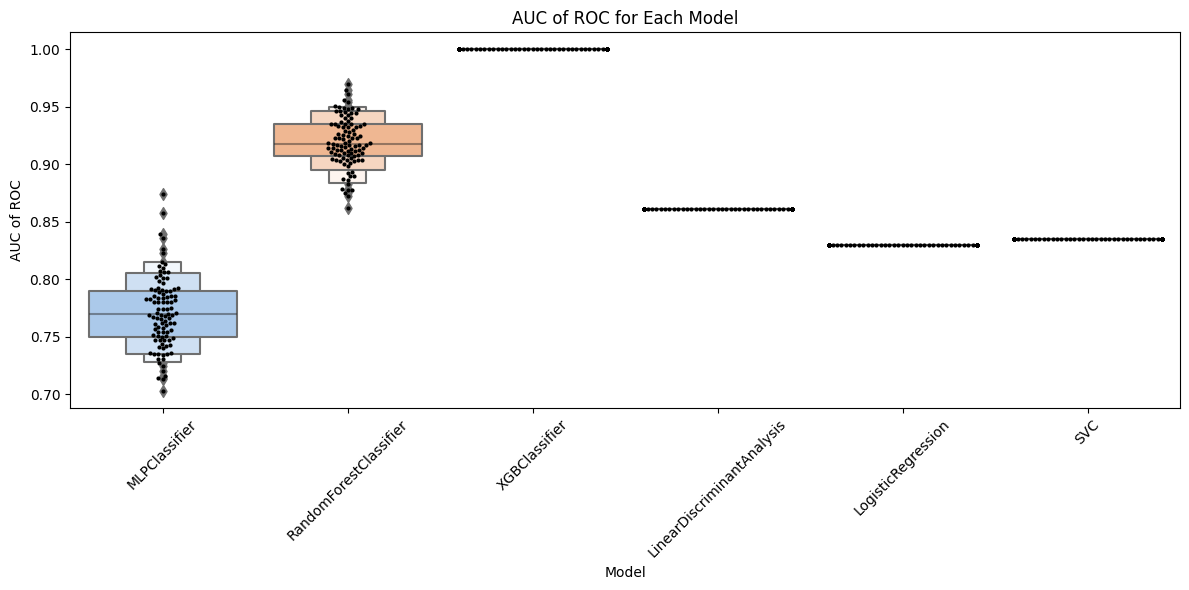

/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 73.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 67.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


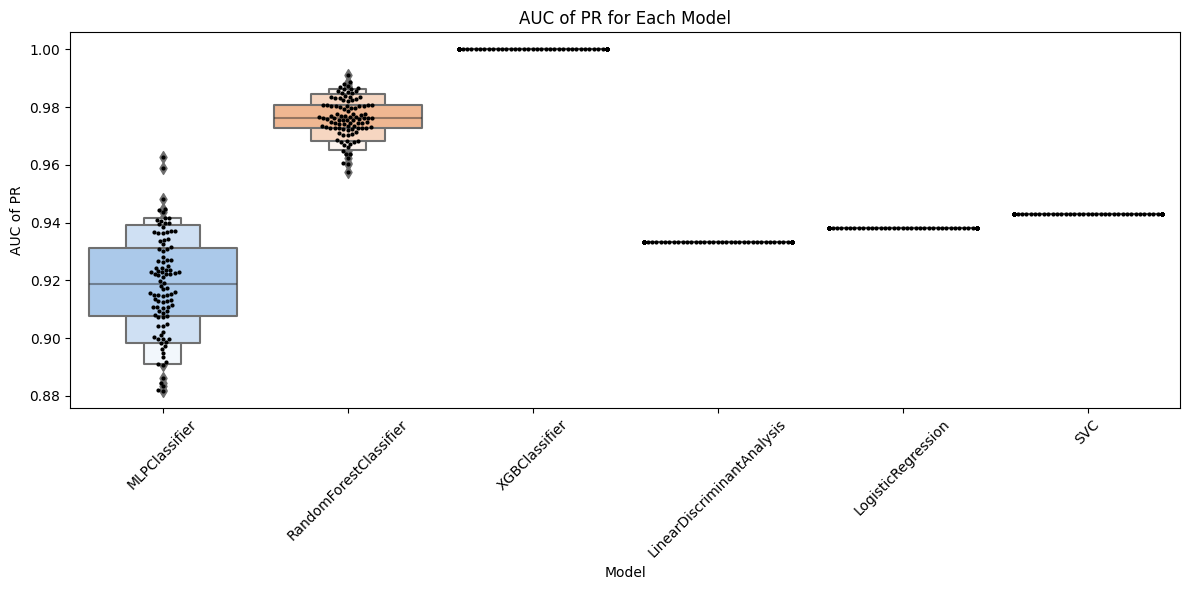

In [47]:
from imblearn.over_sampling import SMOTE
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def bootstrap_evaluation(model, X_train, y_train, X_test, y_test, n_iter=100):
    metrics_list = []
    confusion_matrices = []

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    for i in tqdm(range(n_iter), desc="Bootstrap Iterations"):
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)
        
        # Check if the model has the predict_proba method
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        else:
            y_prob = y_pred  # Use predicted labels as probabilities for models without predict_proba
        
        metrics_list.append(compute_metrics(y_test, y_pred, y_prob))
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(cm)

    metrics_df = pd.DataFrame(metrics_list, columns=['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1', 'MCC', 'ROC_AUC', 'PR_AUC'])
    metrics_df['Model'] = model.__class__.__name__  # Add model name to the DataFrame
    
    return metrics_df

# Assuming classifiers is your list of classifiers and their hyperparameters
all_metrics = []

for clf, params in tqdm(classifiers, desc="Grid Searching", unit="model"):
    grid_search = GridSearchCV(clf, params, cv=5)
    grid_search.fit(X_train, y_train)
    
    # Bootstrap evaluation
    metrics_df = bootstrap_evaluation(grid_search.best_estimator_, X_train, y_train, X_test, y_test)
    all_metrics.append(metrics_df)

# Combine all metrics into a single DataFrame
all_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Reshape the data to long format
long_format = pd.melt(all_metrics_df, id_vars=['Model'], value_vars=['ROC_AUC', 'PR_AUC'])

# Plot AUC of ROC
plt.figure(figsize=(12, 6))
sns.boxenplot(x='Model', y='value', data=long_format[long_format['variable'] == 'ROC_AUC'], palette="pastel")
sns.swarmplot(x='Model', y='value', data=long_format[long_format['variable'] == 'ROC_AUC'], color="black", size=3)
plt.title('AUC of ROC for Each Model')
plt.ylabel('AUC of ROC')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot AUC of PR
plt.figure(figsize=(12, 6))
sns.boxenplot(x='Model', y='value', data=long_format[long_format['variable'] == 'PR_AUC'], palette="pastel")
sns.swarmplot(x='Model', y='value', data=long_format[long_format['variable'] == 'PR_AUC'], color="black", size=3)
plt.title('AUC of PR for Each Model')
plt.ylabel('AUC of PR')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Grid Searching:   0%|          | 0/6 [00:00<?, ?model/s]

/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multi

Bootstrap Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model: MLPClassifier
Accuracy       0.788764
Precision      0.854914
Recall         0.881429
Specificity    0.447368
F1             0.867710
MCC            0.344524
ROC_AUC        0.774812
PR_AUC         0.917963
dtype: float64
Accuracy       0.025301
Precision      0.018430
Recall         0.025644
Specificity    0.081776
F1             0.016419
MCC            0.080745
ROC_AUC        0.034455
PR_AUC         0.019506
dtype: float64
Average Confusion Matrix:
[[ 8.5 10.5]
 [ 8.3 61.7]]
--------------------------------------------------


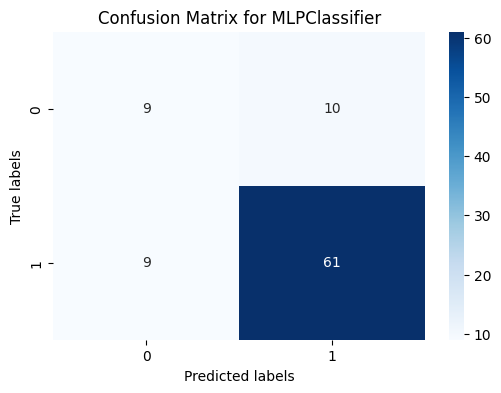

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
200 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "/opt/homebrew/lib/python3.11/site-packag

Bootstrap Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Model: RandomForestClassifier
Accuracy       0.867978
Precision      0.874374
Recall         0.972143
Specificity    0.484211
F1             0.920559
MCC            0.565249
ROC_AUC        0.916154
PR_AUC         0.975535
dtype: float64
Accuracy       0.020845
Precision      0.016283
Recall         0.015246
Specificity    0.075921
F1             0.012305
MCC            0.078374
ROC_AUC        0.022095
PR_AUC         0.006699
dtype: float64
Average Confusion Matrix:
[[ 9.2   9.8 ]
 [ 1.95 68.05]]
--------------------------------------------------


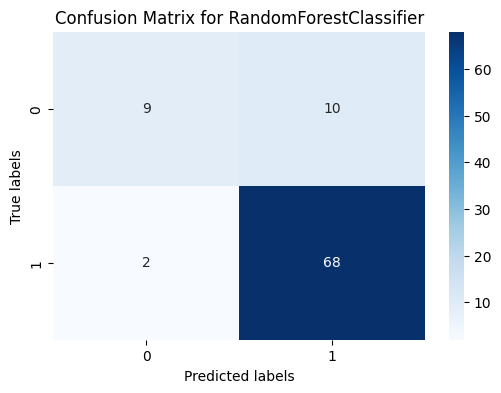

Bootstrap Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Model: XGBClassifier
Accuracy       1.0
Precision      1.0
Recall         1.0
Specificity    1.0
F1             1.0
MCC            1.0
ROC_AUC        1.0
PR_AUC         1.0
dtype: float64
Accuracy       0.0
Precision      0.0
Recall         0.0
Specificity    0.0
F1             0.0
MCC            0.0
ROC_AUC        0.0
PR_AUC         0.0
dtype: float64
Average Confusion Matrix:
[[19.  0.]
 [ 0. 70.]]
--------------------------------------------------


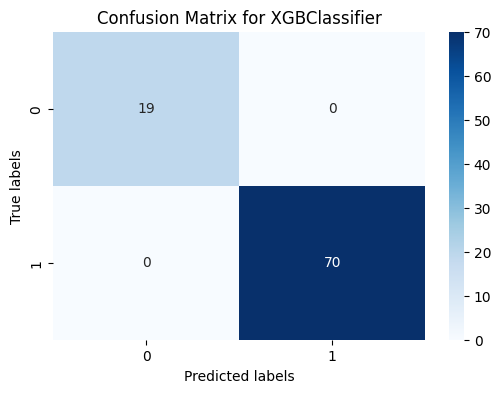

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/discriminant_analysis.py", line 637, in fit
    self._solve_ei

Bootstrap Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Model: LinearDiscriminantAnalysis
Accuracy       0.820225
Precision      0.909091
Recall         0.857143
Specificity    0.684211
F1             0.882353
MCC            0.506723
ROC_AUC        0.860902
PR_AUC         0.933454
dtype: float64
Accuracy       4.463264e-16
Precision      3.347448e-16
Recall         1.115816e-16
Specificity    2.231632e-16
F1             0.000000e+00
MCC            0.000000e+00
ROC_AUC        2.231632e-16
PR_AUC         1.115816e-16
dtype: float64
Average Confusion Matrix:
[[13.  6.]
 [10. 60.]]
--------------------------------------------------


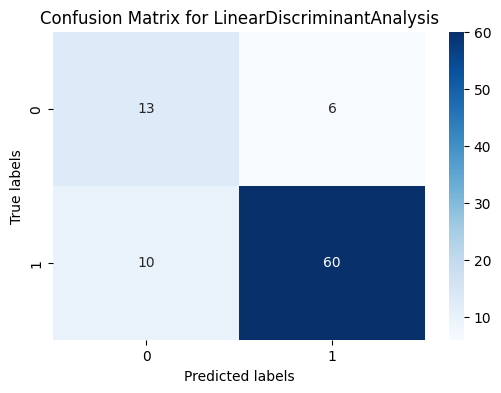

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
105 fits failed out of a total of 210.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1168, in fit
    solver 

Bootstrap Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Model: LogisticRegression
Accuracy       0.831461
Precision      0.848101
Recall         0.957143
Specificity    0.368421
F1             0.899329
MCC            0.422424
ROC_AUC        0.829323
PR_AUC         0.938231
dtype: float64
Accuracy       1.115816e-16
Precision      1.115816e-16
Recall         1.115816e-16
Specificity    5.579081e-17
F1             1.115816e-16
MCC            1.115816e-16
ROC_AUC        1.115816e-16
PR_AUC         2.231632e-16
dtype: float64
Average Confusion Matrix:
[[ 7. 12.]
 [ 3. 67.]]
--------------------------------------------------


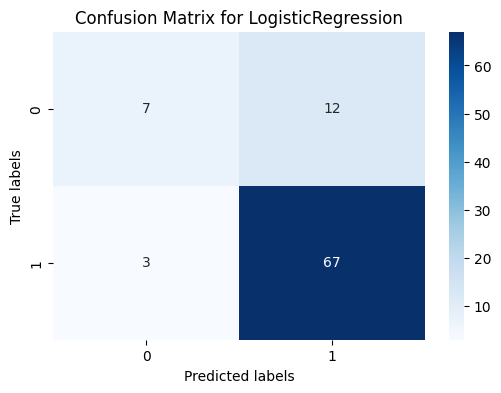

Bootstrap Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Model: SVC
Accuracy       0.820225
Precision      0.837500
Recall         0.957143
Specificity    0.315789
F1             0.893333
MCC            0.370949
ROC_AUC        0.835338
PR_AUC         0.942996
dtype: float64
Accuracy       4.463264e-16
Precision      4.463264e-16
Recall         1.115816e-16
Specificity    0.000000e+00
F1             3.347448e-16
MCC            5.579081e-17
ROC_AUC        2.231632e-16
PR_AUC         3.347448e-16
dtype: float64
Average Confusion Matrix:
[[ 6. 13.]
 [ 3. 67.]]
--------------------------------------------------


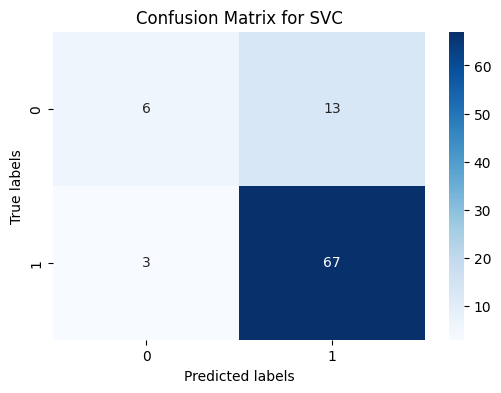

Best Model: XGBClassifier with score 0.9925925925925926


In [45]:
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

best_models = []

# Open the summary.txt file in write mode
with open("summary.txt", "w") as file:

    for clf, params in tqdm(classifiers, desc="Grid Searching", unit="model"):
        grid_search = GridSearchCV(clf, params, cv=5)
        grid_search.fit(X_train, y_train)

        # Bootstrap evaluation
        mean_metrics, std_metrics, avg_cm = bootstrap_evaluation(grid_search.best_estimator_, X_train, y_train, X_test, y_test)
        
        # Write results to the summary.txt file
        file.write(f"Model: {clf.__class__.__name__}\n")
        file.write(str(mean_metrics) + "\n")
        file.write(str(std_metrics) + "\n")
        file.write("Average Confusion Matrix:\n")
        file.write(str(avg_cm) + "\n")
        file.write("-" * 50 + "\n")
        
        print(f"Model: {clf.__class__.__name__}")
        print(mean_metrics)
        print(std_metrics)
        print("Average Confusion Matrix:")
        print(avg_cm)
        print("-" * 50)

        best_models.append((clf.__class__.__name__, grid_search.best_estimator_, grid_search.best_score_))

        # Predict on the test set and print confusion matrix
        y_pred = grid_search.best_estimator_.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
        plt.title(f'Confusion Matrix for {clf.__class__.__name__}')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.show()

    best_models = sorted(best_models, key=lambda x: x[2], reverse=True)
    file.write(f"Best Model: {best_models[0][0]} with score {best_models[0][2]}\n")

print(f"Best Model: {best_models[0][0]} with score {best_models[0][2]}")


In [31]:
# Check the distribution of classes in the original dataset
class_distribution = df['GDvsTI'].value_counts()
print(class_distribution)


GDvsTI
1    173
2     48
Name: count, dtype: int64


In [35]:
y_train

173    0
206    0
0      1
2      1
77     1
      ..
106    1
14     1
92     1
179    0
102    1
Name: GDvsTI, Length: 132, dtype: int64

In [37]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix

N_ITER = 100
metrics_list = []

confusion_matrices = []

# Convert X_train and y_train back to DataFrame for index handling
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.Series(y_train)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_df, y_train_df)

for i in tqdm(range(N_ITER), desc="Bootstrap Iterations"):
    # Train the best model (in this case, Logistic Regression)
    model = LogisticRegression()  # Replace with the best model and its parameters
    model.fit(X_resampled, y_resampled)
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    metrics_list.append(compute_metrics(y_test, y_pred, y_prob))

    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)


# Convert metrics list to DataFrame for easier calculations
metrics_df = pd.DataFrame(metrics_list, columns=['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1', 'MCC', 'ROC_AUC', 'PR_AUC'])

# Compute mean and standard deviation for each metric
mean_metrics = metrics_df.mean()
std_metrics = metrics_df.std()

print(mean_metrics)
print(std_metrics)

# Calculate the average confusion matrix
avg_cm = np.mean(confusion_matrices, axis=0)
print("Average Confusion Matrix:")
print(avg_cm)


Bootstrap Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy       0.842697
Precision      0.858974
Recall         0.957143
Specificity    0.421053
F1             0.905405
MCC            0.470867
ROC_AUC        0.827068
PR_AUC         0.936294
dtype: float64
Accuracy       2.231632e-16
Precision      2.231632e-16
Recall         1.115816e-16
Specificity    1.115816e-16
F1             0.000000e+00
MCC            1.115816e-16
ROC_AUC        0.000000e+00
PR_AUC         0.000000e+00
dtype: float64
Average Confusion Matrix:
[[ 8. 11.]
 [ 3. 67.]]


In [52]:
def bootstrap_sample(X, y):
    n_samples = len(X)
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X.iloc[idxs], y.iloc[idxs]


In [61]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix


# Initialize the model
mlp = MLPClassifier()

# Train the model
mlp.fit(X_train, y_train)

# Predict on the test set
predictions = mlp.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
mcc = matthews_corrcoef(y_test, predictions)
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, predictions)
pr_auc = auc(recall_curve, precision_curve)

print("Evaluation Metrics:")
print("-------------------")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")


# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Extract the individual components
TN, FP, FN, TP = cm.ravel()

print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")



Evaluation Metrics:
-------------------
Accuracy: 0.2135
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient (MCC): 0.0000
ROC AUC: 0.5000
Precision-Recall AUC: 0.8933
True Positives (TP): 0
True Negatives (TN): 19
False Positives (FP): 0
False Negatives (FN): 70


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


feature_importances [0.01398988 0.01381362 0.01378419 ... 0.01373241 0.01373943 0.01230468]


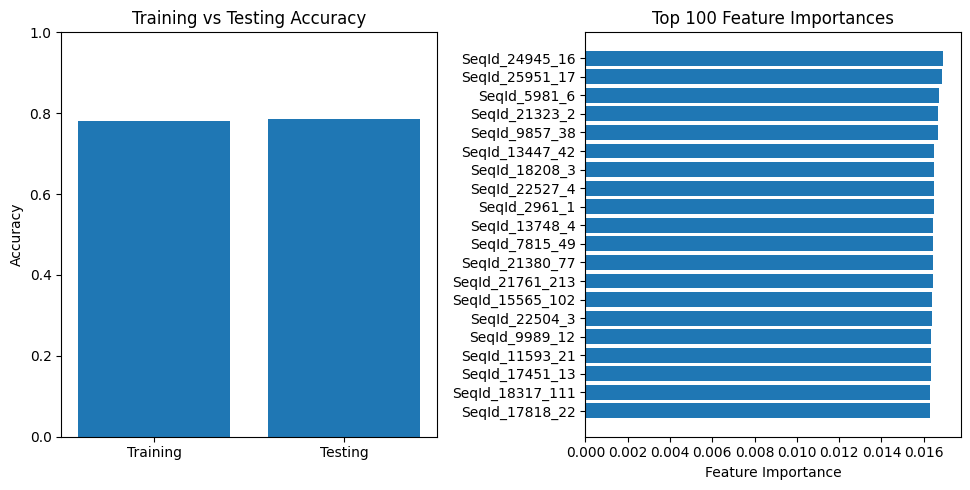

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Plotting Training and Testing Accuracy
train_predictions = mlp.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(['Training', 'Testing'], [train_accuracy, accuracy])
plt.ylim(0, 1)  # set the y-axis limits to be between 0 and 1
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy')

# 2. Plotting Feature Importance
# Using the weights of the first layer as a proxy for feature importance
feature_importances = np.mean(np.abs(mlp.coefs_[0]), axis=1)
sorted_idx = np.argsort(feature_importances)[-20:]  # Get indices of top 100

print("feature_importances", feature_importances)

plt.subplot(1, 2, 2)
plt.barh(range(20), feature_importances[sorted_idx])
plt.yticks(range(20), np.array(features)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Top 100 Feature Importances')

plt.tight_layout()
plt.show()


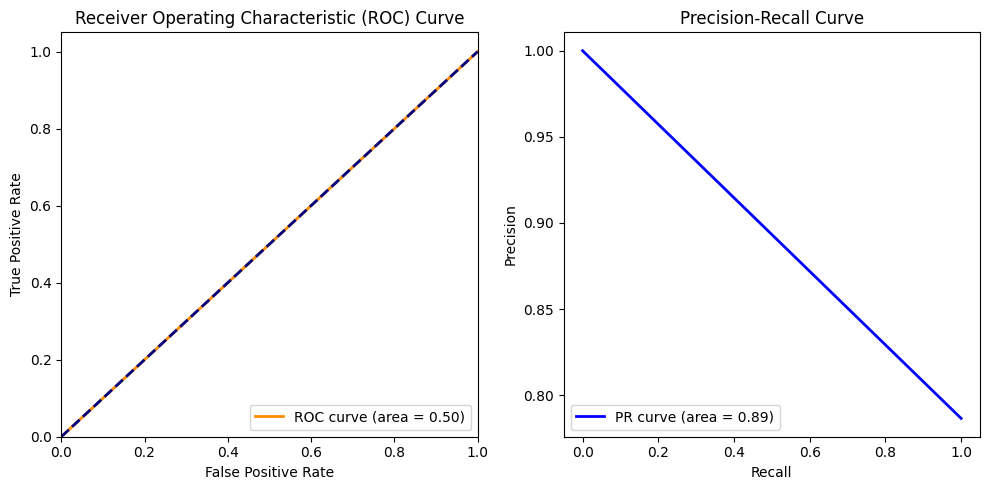

In [54]:
import matplotlib.pyplot as plt

# Plotting the ROC curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plotting the Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, color='blue', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()


In [44]:
def load_data():
    print(f"Loading data from: {DATA_PATH}")
    dataloader = get_dataloader(DATA_PATH, LABEL_COLUMN, batch_size=32, features=features)

    X, y = [], []
    for batch_input, batch_label in dataloader:
        X.append(batch_input.numpy())
        y.append(batch_label.numpy())
    
    return np.vstack(X), np.hstack(y)


In [36]:
features = [col for col in df.columns if col != "GDvsTI"]


In [43]:
X, y = load_data()
best_mcc, best_params, mean_accuracy, std_accuracy, mean_precision, std_precision, mean_recall, std_recall, mean_f1, std_f1, mean_mcc, std_mcc = grid_search_train(X, y)


Loading data from: ./data/kidney_data_final_9.18.23.csv
Features: ['samples', 'SeqId_10000_28', 'SeqId_10001_7', 'SeqId_10003_15', 'SeqId_10006_25', 'SeqId_10008_43', 'SeqId_10010_10', 'SeqId_10011_65', 'SeqId_10012_5', 'SeqId_10014_31', 'SeqId_10015_119', 'SeqId_10022_207', 'SeqId_10023_32', 'SeqId_10024_44', 'SeqId_10025_1', 'SeqId_10030_8', 'SeqId_10035_6', 'SeqId_10036_201', 'SeqId_10037_98', 'SeqId_10039_32', 'SeqId_10040_63', 'SeqId_10041_3', 'SeqId_10042_8', 'SeqId_10043_31', 'SeqId_10045_47', 'SeqId_10046_55', 'SeqId_10047_12', 'SeqId_10049_112', 'SeqId_10053_5', 'SeqId_10054_3', 'SeqId_10056_5', 'SeqId_10058_1', 'SeqId_10063_10', 'SeqId_10064_12', 'SeqId_10069_2', 'SeqId_10070_22', 'SeqId_10073_22', 'SeqId_10074_128', 'SeqId_10076_1', 'SeqId_10078_5', 'SeqId_10081_17', 'SeqId_10082_251', 'SeqId_10085_25', 'SeqId_10086_39', 'SeqId_10087_10', 'SeqId_10089_7', 'SeqId_10339_48', 'SeqId_10344_334', 'SeqId_10346_5', 'SeqId_10351_51', 'SeqId_10354_57', 'SeqId_10356_21', 'SeqId_10361_

ValueError: could not convert string to float: 'Female'

In [39]:
# load_data()
df = pd.read_csv(dataset)
df = pd.get_dummies(df, columns=['sex'])
# print(csv.columns)
columns_to_write = [col for col in df.columns if col != "GDvsTI"]

# Write the columns to a text file
with open('columns.txt', 'w') as f:
    for col in columns_to_write:
        f.write(str(columns_to_write))

In [42]:
len(columns_to_write)

6628

In [40]:
def grid_search_train(X, y):
    best_mcc = -np.inf
    best_params = None
    
    # Lists to store metrics for each bootstrap iteration
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    mccs = []
    rocs = []
    pr_curves = []

    # Generate all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    for i in tqdm(range(N_BOOTSTRAPS)):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4)

        for params in param_combinations:
            model = MLPClassifier(**params)
            model.fit(X_train, y_train)
            predictions = model.predict(X_val)
            
            # Compute metrics
            accuracy = accuracy_score(y_val, predictions)
            precision = precision_score(y_val, predictions)
            recall = recall_score(y_val, predictions)
            f1 = f1_score(y_val, predictions)
            mcc = matthews_corrcoef(y_val, predictions)
            fpr, tpr, _ = roc_curve(y_val, predictions)
            precision_curve, recall_curve, _ = precision_recall_curve(y_val, predictions)
            
            # Store metrics
            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            mccs.append(mcc)
            rocs.append((fpr, tpr))
            pr_curves.append((precision_curve, recall_curve))
            
            if mcc > best_mcc:
                best_mcc = mcc
                best_params = params
                
    # Compute mean and standard deviation for each metric
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    mean_precision = np.mean(precisions)
    std_precision = np.std(precisions)
    mean_recall = np.mean(recalls)
    std_recall = np.std(recalls)
    mean_f1 = np.mean(f1s)
    std_f1 = np.std(f1s)
    mean_mcc = np.mean(mccs)
    std_mcc = np.std(mccs)
    
    return best_mcc, best_params, mean_accuracy, std_accuracy, mean_precision, std_precision, mean_recall, std_recall, mean_f1, std_f1, mean_mcc, std_mcc


In [17]:
def plot_importances(model, X, y):
    result = permutation_importance(model, X, y, n_repeats=30, random_state=0)
    importances = result.importances_mean
    print("importances: ", importances)
    std = result.importances_std
    indices = np.argsort(importances)[::-1]
    print([importances[i] for i in indices])

    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=45, ha="right")
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [15]:
X, y = load_data()
def train_model():
    
    best_score, best_params, mean_accuracy, std_accuracy, mean_precision, std_precision, mean_recall, std_recall, mean_f1, std_f1, mean_mcc, std_mcc = grid_search_train(X, y)
    
    print(f"Best Score (MCC): {best_score}")
    print(f"Best Parameters: {best_params}")
    print(f"Mean Accuracy: {mean_accuracy} ± {std_accuracy}")
    print(f"Mean Precision: {mean_precision} ± {std_precision}")
    print(f"Mean Recall: {mean_recall} ± {std_recall}")
    print(f"Mean F1 Score: {mean_f1} ± {std_f1}")
    print(f"Mean MCC: {mean_mcc} ± {std_mcc}")
    
    # Train final model with best parameters on the entire dataset
    model = MLPClassifier(**best_params)
    model.fit(X, y)
    return model


Loading data from: ./data/kidney_data_final_9.18.23.csv
Features: ['eGFR_CKDEPI2021', 'age', 'SeqId_10011_65', 'SeqId_10024_44', 'SeqId_10040_63', 'SeqId_10042_8']
Label: GDvsTI
dataset.py features:  ['eGFR_CKDEPI2021', 'age', 'SeqId_10011_65', 'SeqId_10024_44', 'SeqId_10040_63', 'SeqId_10042_8']
self.label:  GDvsTI
self.content after filtering:  1
self.x:  [[36.       27.540041 11.332205 10.551516  8.871289  9.807516]
 [64.       52.900753 11.26092   9.368943  9.086667  9.509775]
 [45.       68.3833   11.155451  9.495255  8.844235  9.562433]
 ...
 [ 7.       44.648872 11.84184  11.859729 11.824999  9.809125]
 [39.       49.88912  11.479073  9.371341  8.703212  9.515503]
 [28.       68.952774 11.643631  9.518063  8.836997  9.574972]]
self.y:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 

In [41]:
model = train_model()

  0%|          | 0/100 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/dsert/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/79/vntykx013l36kksv0dcv96580000gn/T/ipykernel_24789/2478850400.py", line 1, in <module>
    model = train_model()
            ^^^^^^^^^^^^^
  File "/var/folders/79/vntykx013l36kksv0dcv96580000gn/T/ipykernel_24789/1840477209.py", line 4, in train_model
    best_score, best_params, mean_accuracy, std_accuracy, mean_precision, std_precision, mean_recall, std_recall, mean_f1, std_f1, mean_mcc, std_mcc = grid_search_train(X, y)
                                                                                                                                                       ^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/79/vntykx013l36kksv0dcv96580000gn/T/ipykernel_24789/1779169109.py", line 23, in grid_search_train
    model.fit(X_train, y_train)
  File "/User

importances:  [-0.00648567 -0.01055807 -0.00739065 -0.00497738 -0.00558069 -0.0040724 ]
[-0.004072398190045298, -0.00497737556561092, -0.005580693815988007, -0.006485671191553614, -0.007390648567119218, -0.010558069381598844]


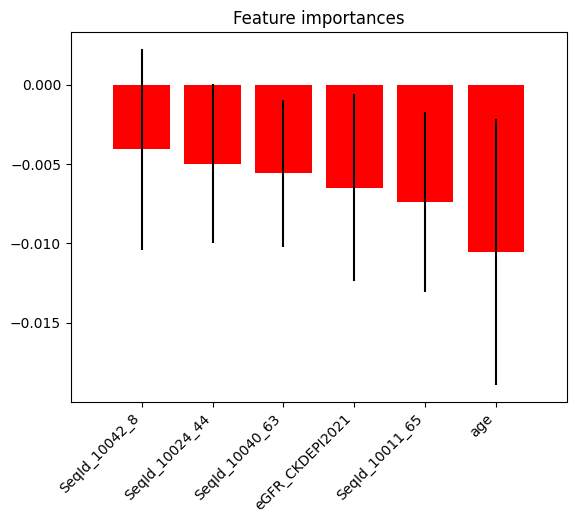

In [18]:
# model = train_model()
# Optional: Save the model
# model.save('./model_weights_sample.pt')
    
# Plot feature importances
plot_importances(model, X, y)

Loading data from: ./data/kidney_data_final_9.18.23.csv
Features: ['eGFR_CKDEPI2021', 'age', 'SeqId_10011_65', 'SeqId_10024_44', 'SeqId_10040_63', 'SeqId_10042_8']
Label: GDvsTI
dataset.py features:  ['eGFR_CKDEPI2021', 'age', 'SeqId_10011_65', 'SeqId_10024_44', 'SeqId_10040_63', 'SeqId_10042_8']
self.label:  GDvsTI
self.content after filtering:  1
self.x:  [[36.       27.540041 11.332205 10.551516  8.871289  9.807516]
 [64.       52.900753 11.26092   9.368943  9.086667  9.509775]
 [45.       68.3833   11.155451  9.495255  8.844235  9.562433]
 ...
 [ 7.       44.648872 11.84184  11.859729 11.824999  9.809125]
 [39.       49.88912  11.479073  9.371341  8.703212  9.515503]
 [28.       68.952774 11.643631  9.518063  8.836997  9.574972]]
self.y:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 

  0%|          | 0/100 [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Score (MCC): 0.49735027281476557
Best Parameters: {'lr': 0.001, 'batch_size': 8}
Mean Accuracy: 0.7440948813982522 ± 0.10437326839560557
Mean Precision: 0.7851868432241933 ± 0.06761454759598423
Mean Recall: 0.9271307119335063 ± 0.17946271043736192
Mean F1 Score: 0.8369338209661358 ± 0.1256986420565416
Mean MCC: 0.027649101073039722 ± 0.10137846450164763


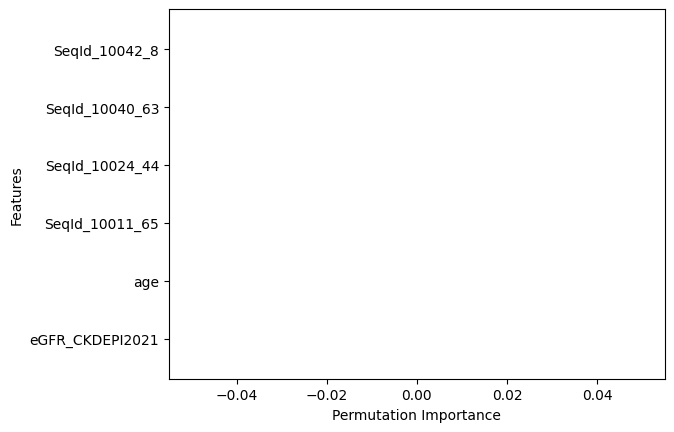